In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit

from stylesheet import *


FileNotFoundError: [Errno 2] No such file or directory: '../data/mnist/sparse_8_20250425-080157/config.yml'

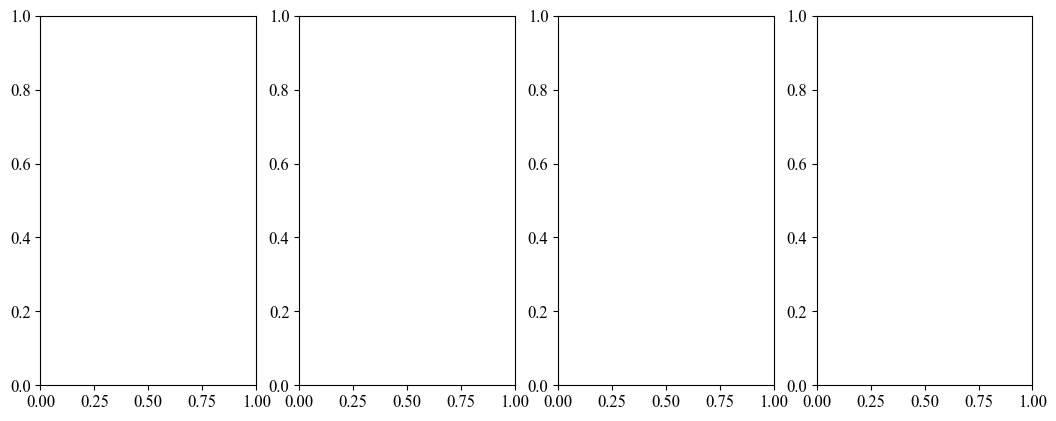

In [2]:
datasets = ['MNIST', 'Fashion-MNIST', 'CIFAR-10', 'Imagenette']
paths_dict = {
    'MNIST': [
        "../data/mnist/sparse_8_20250425-080157",
        "../data/mnist/orthogonal_8_20250306-035734",
        "../data/mnist/unitary_8_20250306-040348",
    ],
    'Fashion-MNIST': [
        "../data/fashion_mnist/sparse_8_20250425-080817",
        "../data/fashion_mnist/orthogonal_8_20250306-051726",
        "../data/fashion_mnist/unitary_8_20250306-052929",
    ],
    'CIFAR-10': [
        "../data/cifar10/sparse_8_20250425-085610",
        "../data/cifar10/cnot_count/cifar10_orthogonal_8_20241217-014108",
        "../data/cifar10/cnot_count/cifar10_unitary_8_20241217-015052",
    ],
    'Imagenette': [
        # "../data/imagenette_128/sparse_8_20250313-094812",
        "../data/imagenette_128/sparse_8_20250425-085727",
        "../data/imagenette_128/_orthogonal_8_20250312-115249",
        "../data/imagenette_128/unitary_8_20250313-094859",
    ]
}
markers = [
    marker["circle"],
    marker["square"],
    marker["triangle"],
    marker["diamond"],
]

colors = [
    color_palette["blue"],
    color_palette["red"],
    color_palette["green"],
    color_palette["orange"],
]

def compute_infidelity(states1, states2):
    return 1 - np.abs(np.sum(np.conj(states1) * states2, axis=1)) ** 2

# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# scale = 0.8
scale = 1
fig, axs = plt.subplots(1, 4, figsize=(12.8*scale, 4.8*scale))

for ax, dataset in zip(axs, datasets):
    paths = paths_dict[dataset]
    all_results = {}
    for path in paths:
        if path.endswith('.csv'):
            assert "imagenette" in path
            n_qubits = 19
            df = pd.read_csv(path)
            if "sparse" in path:
                encoding_name = "sparse"
                cnot_scaler = 1 * (n_qubits - 1)
            elif "orthogonal" in path:
                encoding_name = "orthogonal"
                cnot_scaler = 2 * (n_qubits - 1)
            elif "unitary" in path:
                encoding_name = "unitary"
                cnot_scaler = 3 * (n_qubits - 1)
            mean_infidelities = df["Mean Infidelities"]
            percentiles_25 = df["25th Percentile"]
            percentiles_75 = df["75th Percentile"]
        else:
            with open(f"{path}/config.yml", 'r') as file:
                config = yaml.safe_load(file)
            encoding_name = config['circuit']
            if dataset in ['MNIST', 'Fashion-MNIST']:
                n_qubits = 11
            elif dataset == 'CIFAR-10':
                n_qubits = 13
            elif dataset == 'Imagenette':
                n_qubits = 17
            else:
                raise ValueError(f"Unknown dataset: {dataset}")
            # if dataset == 'Imagenette' and config['circuit'] != 'orthogonal': continue
            if config['circuit'] == 'sparse':
                cnot_scaler = 1 * (n_qubits - 1)
            elif config['circuit'] == 'orthogonal':
                cnot_scaler = 2 * (n_qubits - 1)
            elif config['circuit'] == 'unitary':
                cnot_scaler = 3 * (n_qubits - 1)
            if config['circuit'] == "orthogonal" and dataset == "Imagenette":
                compressed_full = np.load(f"{path}/compressed_100.npy", allow_pickle=True)
            else:
                compressed_full = np.load(f"{path}/compressed.npy", allow_pickle=True)
            frqi_target = np.stack(compressed_full['frqi_target'])
            depths = range(8)
            mean_infidelities = []
            percentiles_25 = []
            percentiles_75 = []
            for d in depths:
                state_key = f'state_{d}'
                if state_key in compressed_full.dtype.names:
                    state_data = np.stack(compressed_full[state_key])
                    infidelities = compute_infidelity(frqi_target, state_data)
                    mean_infidelities.append(infidelities.mean())
                    percentiles_25.append(np.percentile(infidelities, 25))
                    percentiles_75.append(np.percentile(infidelities, 75))
                else:
                    mean_infidelities.append(np.nan)
                    percentiles_25.append(np.nan)
                    percentiles_75.append(np.nan)
        all_results[encoding_name] = (mean_infidelities, percentiles_25, percentiles_75, (np.asarray(depths) + 1) * cnot_scaler)
    ax.plot([], [], ' ', label=r'$\alpha \cdot x^{-\beta}$', color='gray', linestyle='--', linewidth=line_width)
    for i, (encoding_name, data) in enumerate(all_results.items()):
        mean_infidelities, p25, p75, cnot_count = data
        mean_infidelities, p25, p75, cnot_count = mean_infidelities[1:], p25[1:], p75[1:], cnot_count[1:]
        c = colors[i % len(colors)]
        m = markers[i % len(markers)]
        log_x = np.log(cnot_count)
        log_y = np.log(mean_infidelities)
        p, cov = np.polyfit(log_x, log_y, 1, cov=True)
        beta, log_alpha = p
        alpha = np.exp(log_alpha)
        fit_y = alpha * cnot_count**beta
        var_beta = cov[0, 0]
        var_log_alpha = cov[1, 1]
        var_alpha = alpha**2 * var_log_alpha
        std_alpha = np.sqrt(var_alpha)
        std_beta = np.sqrt(var_beta)
        print(f"Dataset: {dataset}, Encoding: {encoding_name}, Alpha: {alpha:.2f} ± {std_alpha:.2f}, Beta: {-beta:.3f} ± {std_beta:.3f}")
        ax.plot(cnot_count, mean_infidelities, marker=m, color=c, markersize=7, linewidth=0, markeredgecolor="black",
                markeredgewidth=markeredgewidth, linestyle='', label=encoding_name)
        ax.fill_between(cnot_count, p25, p75, color=c, alpha=0.2)
        # ax.plot(cnot_count, fit_y, color=c, linestyle='--', linewidth=line_width, label=rf'$\alpha = {alpha:.2f}±{std_alpha:.2f}, \beta = {-beta:.2f}±{std_beta:.2f}$')
        ax.plot(cnot_count, fit_y, color=c, linestyle='--', linewidth=line_width, label=rf'$\alpha = {alpha:.2f},\ \beta = {-beta:.2f}$', zorder=1)
    ax.set_title(dataset)
    ax.set_xlabel('Number of CNOTs')
    ax.grid(True)
    ax.set_yscale('log', base=10)

    # ax.set_xscale('log', base=10)
    # ax.set_xticks([50, 100, 200])

    ax.set_xscale('log', base=2)
    ax.set_xticks([32, 64, 128, 256])
    ax.set_xticklabels(['32', '64', '128', '256']) 
    padding_factor = 0.28
    log_lower_x = np.log2(2**5)
    log_upper_x = np.log2(2**8)
    delta = log_upper_x - log_lower_x

    ax.set_xlim(2 ** (log_lower_x - padding_factor * delta),
                2 ** (log_upper_x + padding_factor * delta))

    ax.set_ylim([2e-3, 2e-1])
    
    # ylim = ax.get_ylim()
    # ax.set_ylim([ylim[0] * 0.5, ylim[1]])


    handles, labels = ax.get_legend_handles_labels()
    handles, labels = ax.get_legend_handles_labels()
    ax.add_artist(ax.legend([handles[2], handles[4], handles[6]], [labels[2], labels[4], labels[6]], loc='lower left', handlelength=handlelength))
    if dataset == "MNIST": 
        ax.set_ylabel('Infidelity')
        labels[1] = 'Sparse'
        labels[3] = '$SO(4)$'
        labels[5] = '$SU(4)$'
        ax.add_artist(ax.legend([handles[1], handles[3], handles[5], handles[0]], [labels[1], labels[3], labels[5], labels[0]], loc='upper right', handlelength=handlelength))
    else:
        ax.set_yticklabels([])

    # if dataset == "Imagenette": 
    #     ax.set_ylim([9.1e-3, 1.2e-1])

plt.tight_layout()
plt.savefig('encoding_cnot_infid.pdf')
plt.show()